In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import mu, get_velocity_profile
load_style_sheet("papers")
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


In [2]:
output = vice.output("../outputs/river/insideout-new-nomig")
# output = vice.output("../outputs/linear/dvdr-0p05")

/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_83673/1120643998.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


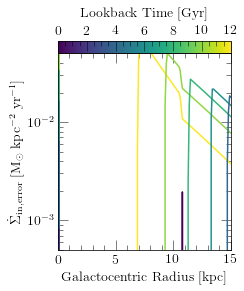

In [38]:
LOOKBACKS = [0.01, 2, 4, 6, 8, 10, 12][::-1]
COLORMAP = "viridis"

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot \Sigma_\text{in,error}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax.set_yscale("log")
ax.set_xlim([0, 15])
ax.set_ylim([5.e-4, 0.05])

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal")
cbar.set_label("Lookback Time [Gyr]", labelpad = 8)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12])

def plot_snapshot(output, lookback, zone_width = 0.1, **kwargs):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, mu_gas, mu_o = mu(output, lookback, zone_width = zone_width)
    else:
        radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
        mu_gas = len(radii) * [0.]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    err = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        area = np.pi * ((radii[i] + zone_width)**2 - radii[i]**2)
        try:
            dmgdt = (zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]) / (
                zone.history["lookback"][idx] - zone.history["lookback"][idx + 1]) * 1.e-9
        except:
            print(idx)
            print(len(zone.history["mgas"]))
            raise
        if zone.history["sfr"][idx]:
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            eta = 0
        expected = dmgdt + zone.history["sfr"][idx] * (1 + eta -
            mu_gas[i] - zone.history["R_eff"][idx])
        expected /= area
        actual = zone.history["ifr"][idx] / area
#         err.append(expected - actual)
#         err.append(actual - expected)
#         err.append(dmgdt)
#         err.append(expected)
        err.append(actual)
#         if err[-1] > 0.01: print(actual, expected)
    ax.plot(radii[:-1], err, **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i])
    }
    plot_snapshot(output, LOOKBACKS[i], **kwargs)

plt.tight_layout()
cbar_ax.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.05
])
plt.show()

/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_73925/2358223417.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


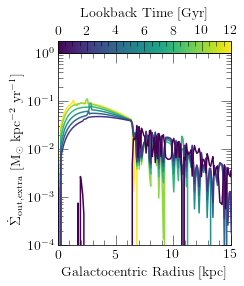

In [3]:
LOOKBACKS = [0.01, 2, 4, 6, 8, 10, 12][::-1]
COLORMAP = "viridis"

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot \Sigma_\text{out,extra}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax.set_xlim([0, 15])
ax.set_yscale("log")
ax.set_ylim([1.e-4, 1])

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal")
cbar.set_label("Lookback Time [Gyr]", labelpad = 8)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12])

def plot_snapshot(output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [(i + 0.5) * zone_width for i in range(len(output.zones.keys()))]
    sigma_out_extra = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        expected = zone.history["eta_0"][idx] * zone.history["sfr"][idx]
        actual = zone.history["ofr"][idx]
        sigma_out_extra.append(actual - expected)
    ax.plot(radii, sigma_out_extra, **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i])
    }
    plot_snapshot(output, LOOKBACKS[i], **kwargs)

plt.tight_layout()
cbar_ax.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.05
])
plt.show()